In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, Flatten, Conv2D, MaxPooling2D, LayerNormalization, Softmax
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
import tensorflow_probability as tfp
import keras

In [2]:
#training, testing = tf.keras.datasets.mnist.load_data(path="mnist.npz")
training, testing = tf.keras.datasets.fashion_mnist.load_data()



images_training = training[0]/256
images_testing = testing[0]/256

labels_training = pd.get_dummies(training[1]).to_numpy()
labels_testing = pd.get_dummies(testing[1]).to_numpy()

In [57]:
def generate_gaussian_noise(images,noise_sd):
    #Adds random gaussian noise to images
    noisy_images = images + np.random.normal(0,noise_sd,np.shape(images))
    return noisy_images


def generate_contrast(images,a):
    
    contrasted_images = np.zeros(np.shape(images))
    #changes contrast based on alpha
    alpha = a
    for i in range(np.shape(images)[0]):
        for j in range(np.shape(images)[1]):
            for k in range(np.shape(images)[2]):
                if images[i,j,k] < 0.5:
                    contrasted_images[i,j,k] = 0.5*(2*images[i,j,k])**alpha
                    
                else:
                    contrasted_images[i,j,k] = 1 - 0.5*(2*(1-images[i,j,k]))**alpha
    
    return contrasted_images

def generate_pixel_dropout(images,dropout, replace=0.5):
    dropout_images = np.zeros(np.shape(images))

    for i in range(np.shape(images)[0]):
        for j in range(np.shape(images)[1]):
            for k in range(np.shape(images)[2]):
                if np.random.rand(1,)[0] < dropout:
                    dropout_images[i,j,k] = replace
                else:
                    dropout_images[i,j,k] = images[i,j,k]                       
                    
     
    
    return dropout_images

def display_images(images,n=10):
    #Displays first n images
    plt.figure(10000)
    fig, ax = plt.subplots(1,n,figsize=(15,15))
    for i in range(n):
        ax[i].imshow(images[i])  
    plt.show()
    
def compute_accuracy(actual_labels, predicted_labels):
    c = 0
    for i in range(len(actual_labels[:,0])):
        if np.argmax(actual_labels[i,:]) == np.argmax(predicted_labels[i,:]):
            c = c+1
            
    return c/len(actual_labels[:,0])
        
def compute_confidence(actual_labels, predicted_labels):
    c = 0
    all_conf = 0 
    correct_conf = 0
    for i in range(len(actual_labels[:,0])):
        if np.argmax(actual_labels[i,:]) == np.argmax(predicted_labels[i,:]):
            c = c+1
            correct_conf = predicted_labels[i,np.argmax(predicted_labels[i,:])] + correct_conf
        all_conf = predicted_labels[i,np.argmax(predicted_labels[i,:])] + all_conf
        
    all_conf = all_conf/len(actual_labels[:,0])
    correct_conf = correct_conf/c
    
    return all_conf,correct_conf

def compute_frequencies(predicted_labels):
    freq = np.zeros((10,1))
    for i in range(len(predicted_labels[:,0])): 
        freq[np.argmax(predicted_labels[i,:]),0] = 1 + freq[np.argmax(predicted_labels[i,:]),0]
        
    freq = freq/len(predicted_labels[:,0])
        
    return freq
        
    
def compute_confidence_by_category(actual_labels, predicted_labels):
    c = np.zeros((10,1))
    cc = np.zeros((10,1))
    all_conf = np.zeros((10,1))
    correct_conf = np.zeros((10,1))
    
    for j in range(10):
        for i in range(len(actual_labels[:,0])):
            if np.argmax(predicted_labels[i,:]) == j:
                cc[j] = cc[j] + 1
                if np.argmax(actual_labels[i,:]) == np.argmax(predicted_labels[i,:]):
                    c[j] = c[j]+1
                    correct_conf[j] = predicted_labels[i,np.argmax(predicted_labels[i,:])] + correct_conf[j]
                all_conf[j] = predicted_labels[i,np.argmax(predicted_labels[i,:])] + all_conf[j]

        all_conf[j] = all_conf[j]/cc[j]
        correct_conf[j] = correct_conf[j]/c[j]
    
    return all_conf,correct_conf


def compute_hidden_cluster_info(hidden_activations, labels):
    num_classes = np.shape(labels)[1]
    num_activations = np.shape(hidden_activations)[1]
        
    categorical_centers = np.zeros((num_activations,num_classes))    
    all_centers = np.zeros((num_activations,1))
    
    class_counts = np.sum(labels,axis=0)
    
    #Compute centers
    for i in range(np.shape(labels)[0]):
        for j in range(num_classes):
            if np.argmax(labels[i,:]) == j:
                categorical_centers[:,j] = categorical_centers[:,j] + hidden_activations[i,:]/class_counts[j]
                
        all_centers[:,0] = all_centers[:,0] + hidden_activations[i,:]/np.shape(labels)[0]
        
    #Compute distances
    distances = np.zeros(num_classes,)
    
    for i in range(num_classes):
        distances[i] = np.sqrt(np.sum((categorical_centers[:,i] - all_centers[:,0])**2))
        
        
    categorical_ratios = np.zeros(num_classes,)
    #Compute average ratio of dist to categorical center to main center
    for j in range(num_classes):
        
        ratios = []     
        
        for i in range(np.shape(labels)[0]):
            main_dist = np.sqrt(np.sum((hidden_activations[i,:] - all_centers[:,0])**2)) 
            if np.argmax(labels[i,:]) == j:
                cat_dist = np.sqrt(np.sum((hidden_activations[i,:] - categorical_centers[:,j])**2))
        
                ratio = main_dist/cat_dist
        
                ratios.append(ratio)
            
        categorical_ratios[j] = np.mean(ratios)
        
        
        
    return distances, categorical_centers, all_centers, categorical_ratios

def compute_cluster_differences(categorical_centers,categorical_centers__control):
    
    num_classes = np.shape(categorical_centers)[1]
    
    for i in range(num_classes):
        distances[i] = np.sqrt(np.sum((categorical_centers[:,i] - categorical_centers__control[:,i])**2))
        
    return distances


def compute_distance_ratios(categorical_centers_training, hidden_activations_testing):
    #Computes average ratio of the 1st closes categorical cluster to second for all samples
    
    numClass = np.shape(categorical_centers_training)[1]
    
  
    ratios = []
    
    for i in range(np.shape(hidden_activations_testing)[0]):
        distance = np.zeros(numClass,)
        for j in range(numClass):
            distance[j] = np.sqrt(np.sum((categorical_centers_training[:,j] - hidden_activations_testing[i,:])**2))
            
        distance_sort = np.sort(distance)
        
        ratios.append(distance_sort[0]/distance_sort[1])
        
    return np.mean(ratios)

Clean Data


<Figure size 432x288 with 0 Axes>

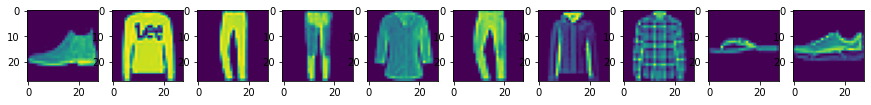

Noisy Data


<Figure size 432x288 with 0 Axes>

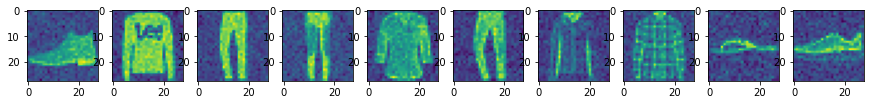

<Figure size 432x288 with 0 Axes>

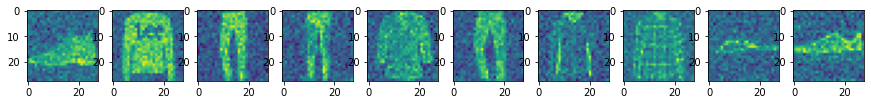

<Figure size 432x288 with 0 Axes>

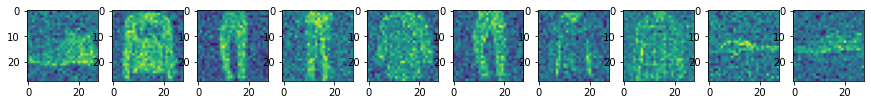

<Figure size 432x288 with 0 Axes>

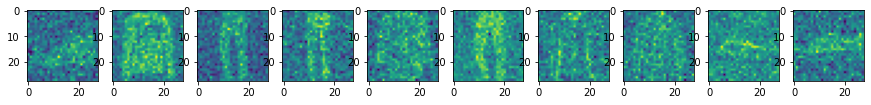

<Figure size 432x288 with 0 Axes>

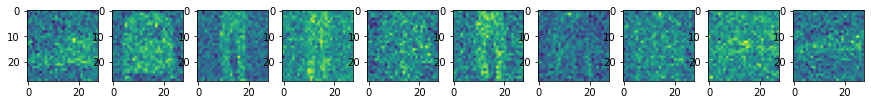

<Figure size 432x288 with 0 Axes>

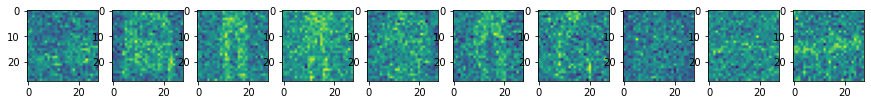

<Figure size 432x288 with 0 Axes>

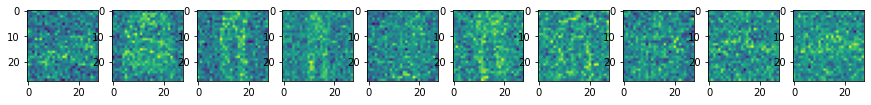

<Figure size 432x288 with 0 Axes>

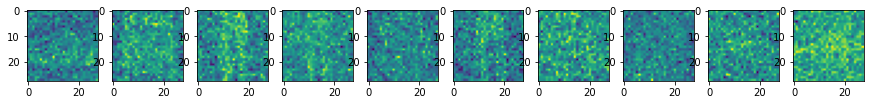

<Figure size 432x288 with 0 Axes>

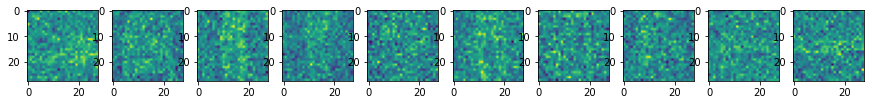

<Figure size 432x288 with 0 Axes>

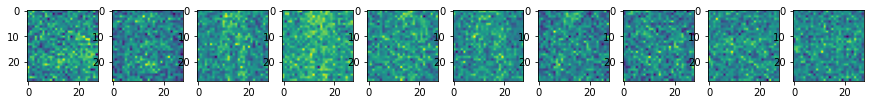

<Figure size 432x288 with 0 Axes>

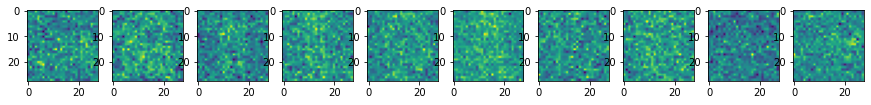

<Figure size 432x288 with 0 Axes>

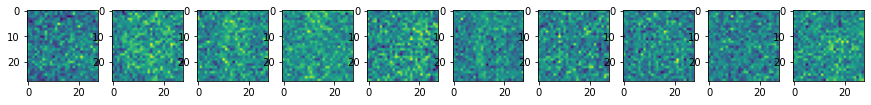

<Figure size 432x288 with 0 Axes>

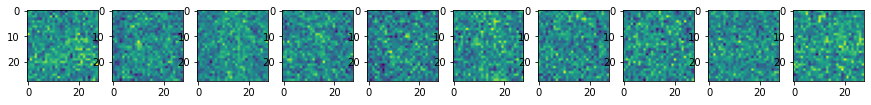

<Figure size 432x288 with 0 Axes>

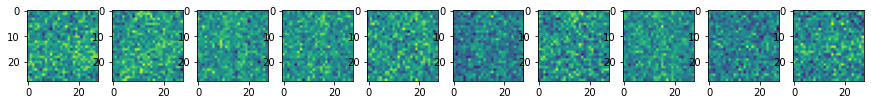

<Figure size 432x288 with 0 Axes>

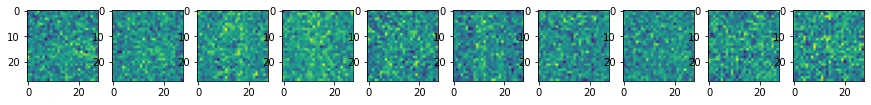

<Figure size 432x288 with 0 Axes>

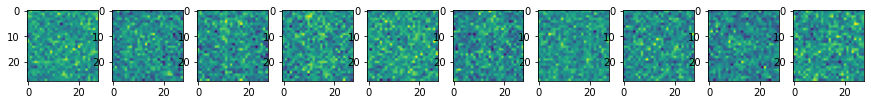

<Figure size 432x288 with 0 Axes>

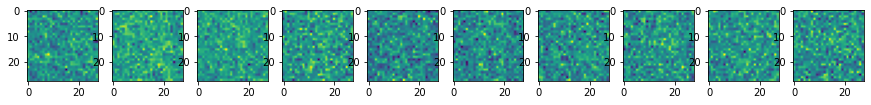

<Figure size 432x288 with 0 Axes>

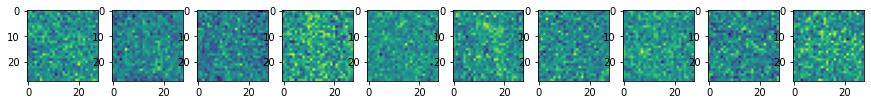

<Figure size 432x288 with 0 Axes>

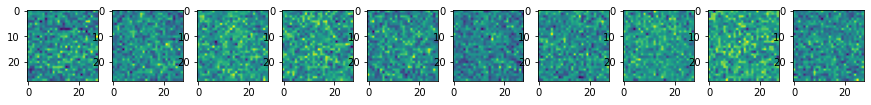

In [4]:
#Display clean data
print("Clean Data")
display_images(images_testing)

print("Noisy Data")
sd_test = np.arange(0.1,2,0.1)
for i in range(len(sd_test)):
    noisy_testing = generate_gaussian_noise(images_testing,sd_test[i])
    
    display_images(noisy_testing)
  

Contrast Data


<Figure size 432x288 with 0 Axes>

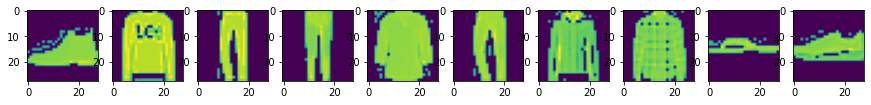

<Figure size 432x288 with 0 Axes>

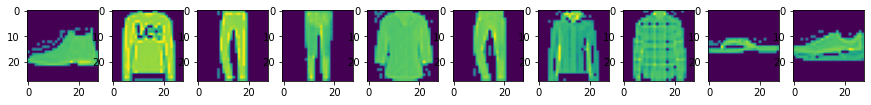

<Figure size 432x288 with 0 Axes>

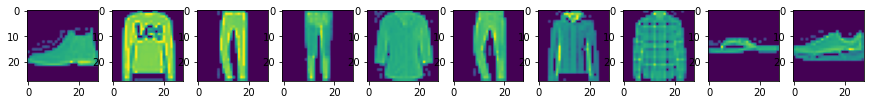

<Figure size 432x288 with 0 Axes>

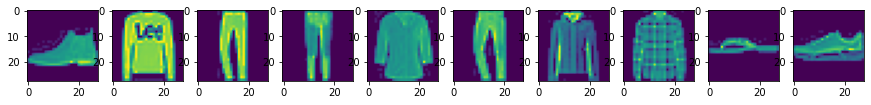

<Figure size 432x288 with 0 Axes>

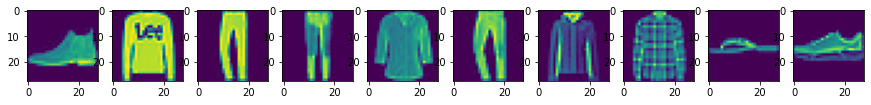

<Figure size 432x288 with 0 Axes>

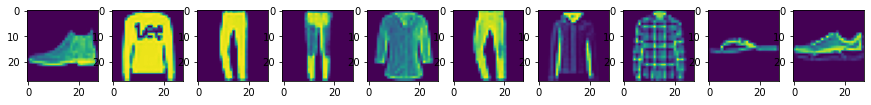

<Figure size 432x288 with 0 Axes>

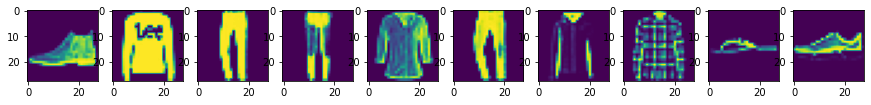

<Figure size 432x288 with 0 Axes>

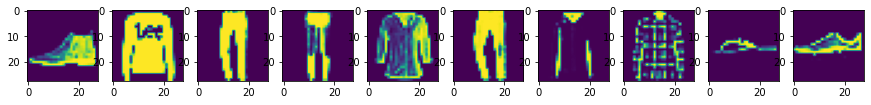

In [5]:
#Display contrast data


print("Contrast Data")
cn_test = [0.05, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4]
for i in range(len(cn_test)):
    noisy_testing = generate_contrast(images_testing,cn_test[i])
    
    display_images(noisy_testing)
  

Dropout Data


<Figure size 432x288 with 0 Axes>

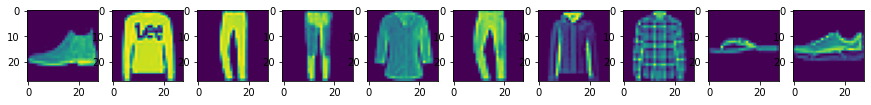

<Figure size 432x288 with 0 Axes>

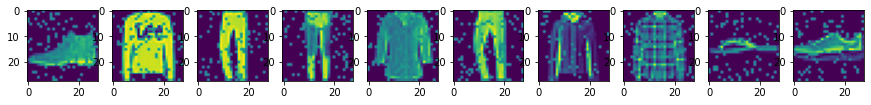

<Figure size 432x288 with 0 Axes>

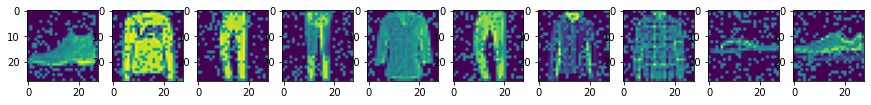

<Figure size 432x288 with 0 Axes>

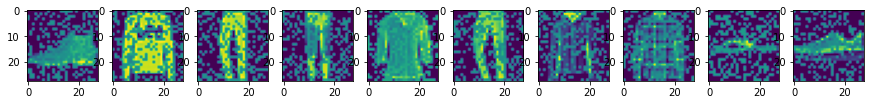

<Figure size 432x288 with 0 Axes>

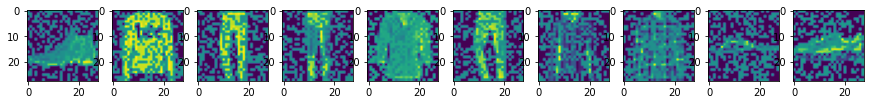

<Figure size 432x288 with 0 Axes>

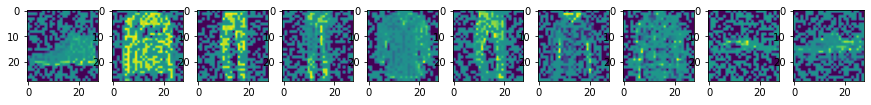

<Figure size 432x288 with 0 Axes>

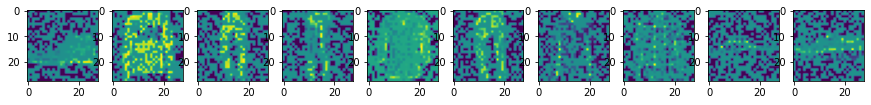

<Figure size 432x288 with 0 Axes>

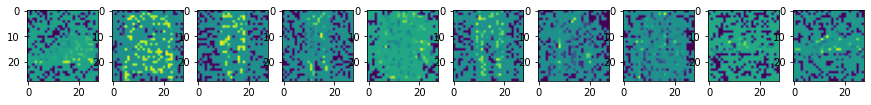

<Figure size 432x288 with 0 Axes>

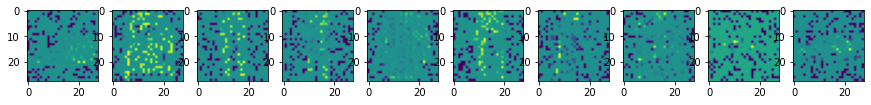

<Figure size 432x288 with 0 Axes>

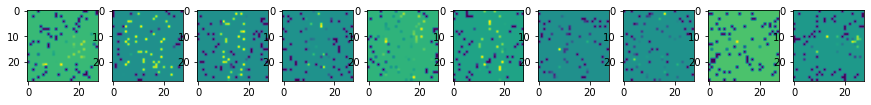

In [6]:
print("Dropout Data")
sd_test = np.arange(0,1,0.1)
for i in range(len(sd_test)):
    noisy_testing = generate_pixel_dropout(images_testing,sd_test[i])
    
    display_images(noisy_testing)

# Experiment 1a: Tiny Feedforward Network

In [7]:
#Train standard feedforward model

images_training_flat = images_training.reshape(np.shape(images_training)[0],784)

inputs = Input(shape=(784))
layer = Dense(10,activation='relu')(inputs)


outputs = Dense(10,activation='softmax')(layer)

model_feedforward = Model(inputs=inputs,outputs=outputs)

model_feedforward_intermed = Model(inputs=inputs,outputs=layer)

model_feedforward.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_feedforward.fit(images_training_flat,labels_training,batch_size=100,verbose = 0, epochs=500,validation_split=0.33,callbacks=[es])


Epoch 47: early stopping


1875/1875 [==============================] - 3s 2ms/step


<Figure size 432x288 with 0 Axes>

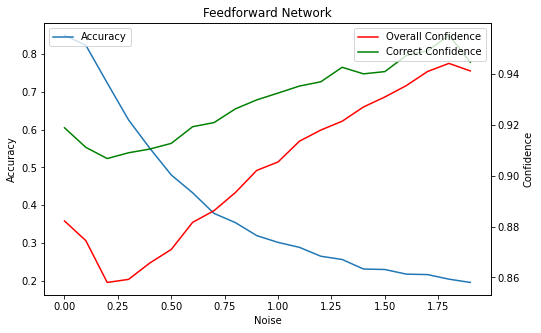

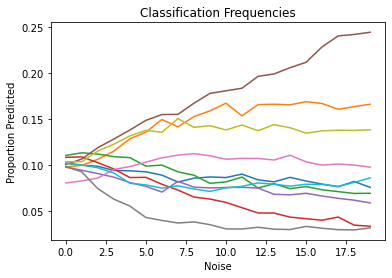

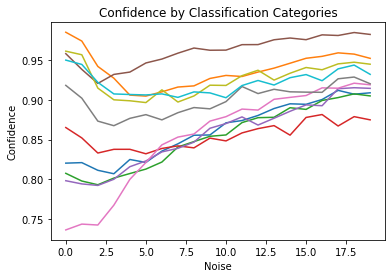

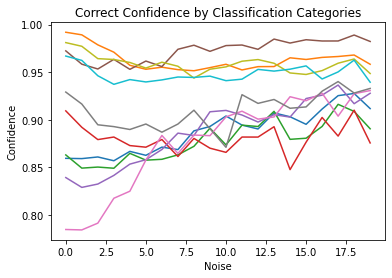

<Figure size 432x288 with 0 Axes>

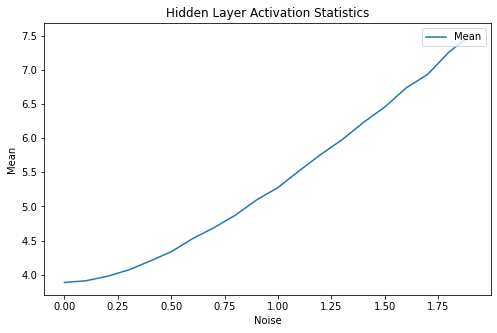

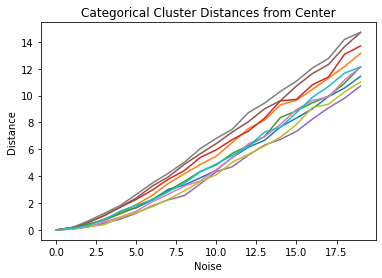

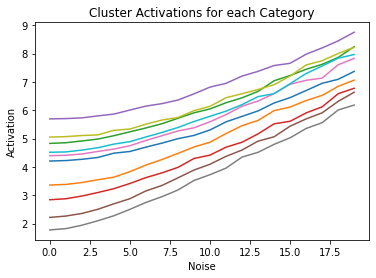

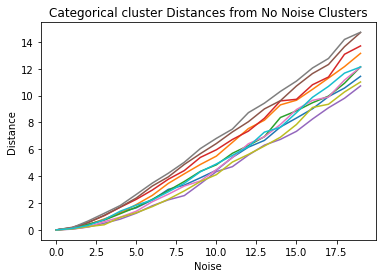

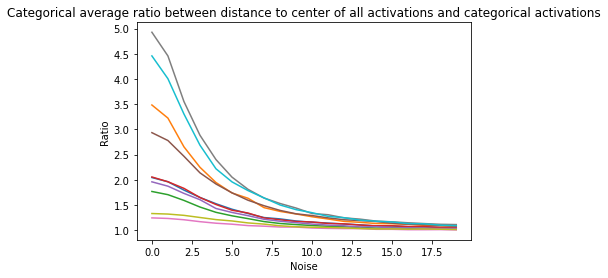

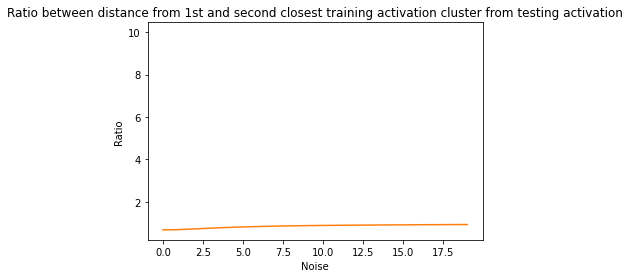

In [58]:
# Vary noise


sd_test = np.arange(0,2,.1)

all_conf_array = []
correct_conf_array = []
acc_array = []

conf_cat_all_array = np.empty((10,0))
conf_cat_correct_array = np.empty((10,0))
freq_all = np.empty((10,0))

activation_mean = []

all_distances = np.empty((10,0))
all_distances_control = np.empty((10,0))
all_centers = np.empty((10,0))

all_ratios = np.empty((10,0))

all_dist_ratio = []

for i in range(len(sd_test)):
    images_testing_noise = generate_gaussian_noise(images_testing,sd_test[i])
    images_testing_noise_flat = images_testing_noise.reshape(np.shape(images_testing_noise)[0],784)
    labels_testing_predicted = model_feedforward.predict(images_testing_noise_flat)
    
    all_conf,correct_conf = compute_confidence(labels_testing,labels_testing_predicted)
    acc = compute_accuracy(labels_testing,labels_testing_predicted)
    
    all_conf_array.append(all_conf)
    correct_conf_array.append(correct_conf)   
    acc_array.append(acc)
    
    freq = compute_frequencies(labels_testing_predicted)
    
    freq_all = np.hstack((freq_all,freq))
    
    conf_cat_all, conf_cat_correct = compute_confidence_by_category(labels_testing,labels_testing_predicted)
    

    
    conf_cat_all_array = np.hstack((conf_cat_all_array,conf_cat_all))
    conf_cat_correct_array = np.hstack((conf_cat_correct_array,conf_cat_correct))
    
    
    hidden_activation = model_feedforward_intermed.predict(images_testing_noise_flat)
    
    
    if i == 0:
        distances, categorical_centers_nonoise, centers, categorical_ratios = compute_hidden_cluster_info(hidden_activation, labels_testing)
    
    
    distances, categorical_centers, centers, categorical_ratios = compute_hidden_cluster_info(hidden_activation, labels_testing)
    
    distances_control = compute_cluster_differences(categorical_centers,categorical_centers_nonoise)
    

    
    mean_categorical_centers = np.mean(categorical_centers,axis=0)
    
    all_ratios = np.hstack((all_ratios,categorical_ratios[:,np.newaxis]))    
  
    all_distances = np.hstack((all_distances,distances[:,np.newaxis]))
    all_distances_control = np.hstack((all_distances_control,distances_control[:,np.newaxis]))
    
    all_centers = np.hstack((all_centers,mean_categorical_centers[:,np.newaxis]))
    
    activation_mean.append(np.mean(hidden_activation))
    
    hidden_activation_training = model_feedforward_intermed.predict(images_training_flat)
    distances_training, categorical_centers_training, centers_training, categorical_ratios_training = compute_hidden_cluster_info(hidden_activation_training, labels_training)
    
    dist_ratio = compute_distance_ratios(categorical_centers_training, hidden_activation)
    
    all_dist_ratio.append(dist_ratio)

plt.figure(1)
fig, acc_ax = plt.subplots(figsize=(8,5))
conf_ax = acc_ax.twinx()
acc_ax.set_xlabel("Noise")
acc_ax.set_ylabel("Accuracy")
conf_ax.set_ylabel("Confidence")
acc_ax.plot(sd_test,acc_array, label = "Accuracy")
conf_ax.plot(sd_test,all_conf_array, label = "Overall Confidence",color='r')
conf_ax.plot(sd_test,correct_conf_array, label = "Correct Confidence",color='g')
plt.title("Feedforward Network")
conf_ax.legend(loc= "upper right")
acc_ax.legend(loc= "upper left")
plt.show()

plt.figure(2)
for i in range(10):
    plt.plot(freq_all[i,:])

plt.xlabel("Noise")
plt.ylabel("Proportion Predicted")
plt.title("Classification Frequencies")
plt.show()

plt.figure(3)
for i in range(10):
    plt.plot(conf_cat_all_array[i,:])

plt.xlabel("Noise")
plt.ylabel("Confidence")
plt.title("Confidence by Classification Categories")
plt.show()

plt.figure(4)
for i in range(10):
    plt.plot(conf_cat_correct_array[i,:])

plt.xlabel("Noise")
plt.ylabel("Confidence")
plt.title("Correct Confidence by Classification Categories")
plt.show()


plt.figure(5)
fig, mean_ax = plt.subplots(figsize=(8,5))
#var_ax = mean_ax.twinx()
mean_ax.set_xlabel("Noise")
mean_ax.set_ylabel("Mean")
#var_ax.set_ylabel("Variance")
mean_ax.plot(sd_test,activation_mean, label = "Mean")
#var_ax.plot(sd_test,activation_var, label = "Var",color='r')
plt.title("Hidden Layer Activation Statistics")
mean_ax.legend(loc= "upper right")
#var_ax.legend(loc= "upper left")
plt.show()

plt.figure(6)
for i in range(10):
    plt.plot(all_distances[i,:])

plt.xlabel("Noise")
plt.ylabel("Distance")
plt.title("Categorical Cluster Distances from Center")
plt.show()

plt.figure(7)
for i in range(10):
    plt.plot(all_centers[i,:])

plt.xlabel("Noise")
plt.ylabel("Activation")
plt.title("Cluster Activations for each Category")
plt.show()

plt.figure(8)
for i in range(10):
    plt.plot(all_distances_control[i,:])

plt.xlabel("Noise")
plt.ylabel("Distance")
plt.title("Categorical cluster Distances from No Noise Clusters")
plt.show()

plt.figure(9)
for i in range(10):
    plt.plot(all_ratios[i,:])

plt.xlabel("Noise")
plt.ylabel("Ratio")
plt.title("Categorical average ratio between distance to center of all activations and categorical activations")
plt.show()

plt.figure(10)
plt.plot(all_dist_ratio)
plt.xlabel("Noise")
plt.ylabel("Ratio")
plt.title("Ratio between distance from 1st and second closest training activation cluster from testing activation")
plt.show()

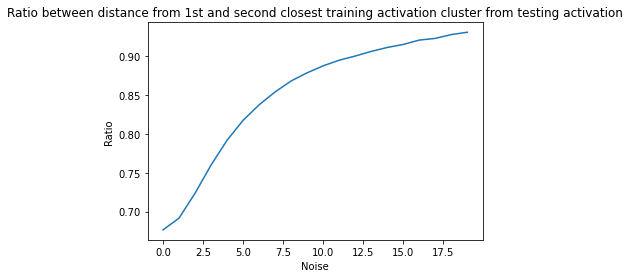

In [61]:
plt.figure(10)
plt.plot(all_dist_ratio)
plt.xlabel("Noise")
plt.ylabel("Ratio")
plt.title("Ratio between distance from 1st and second closest training activation cluster from testing activation")
plt.show()

<Figure size 640x480 with 0 Axes>

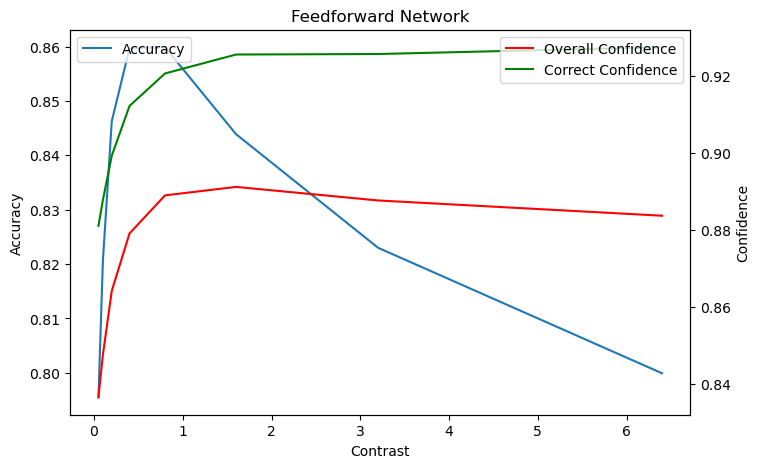

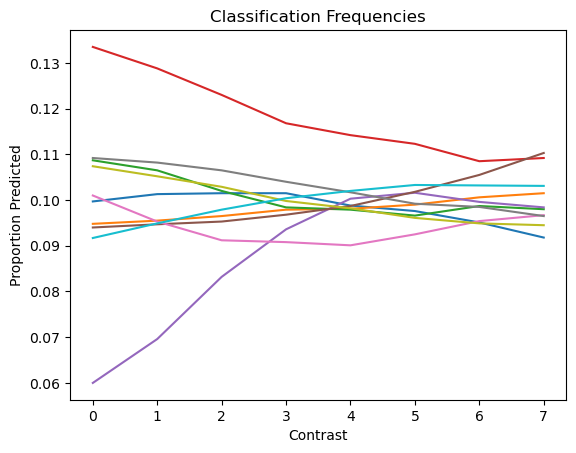

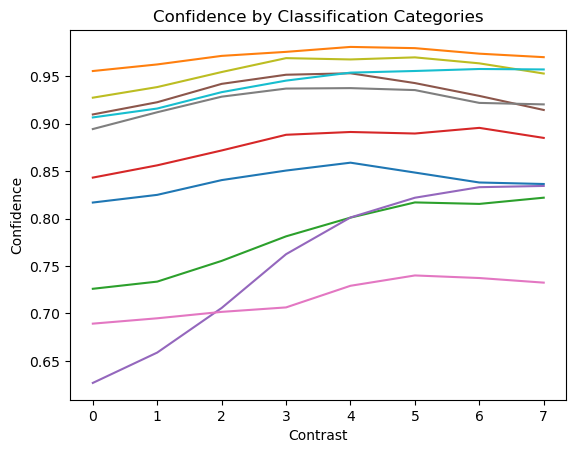

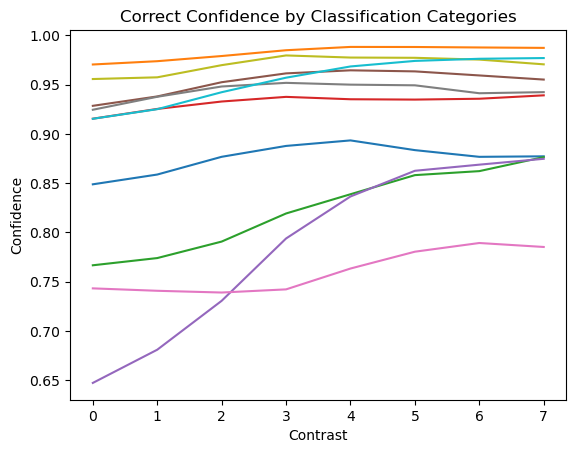

<Figure size 640x480 with 0 Axes>

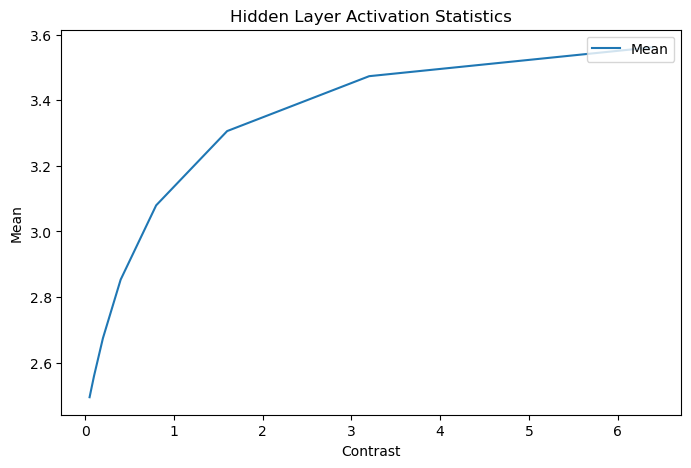

In [10]:
# Vary contrast


cn_test = [0.05, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4]

all_conf_array = []
correct_conf_array = []
acc_array = []

conf_cat_all_array = np.empty((10,0))
conf_cat_correct_array = np.empty((10,0))
freq_all = np.empty((10,0))

activation_mean = []

for i in range(len(cn_test)):
    images_testing_noise = generate_contrast(images_testing,cn_test[i])
    images_testing_noise_flat = images_testing_noise.reshape(np.shape(images_testing_noise)[0],784)
    labels_testing_predicted = model_feedforward.predict(images_testing_noise_flat)
    
    all_conf,correct_conf = compute_confidence(labels_testing,labels_testing_predicted)
    acc = compute_accuracy(labels_testing,labels_testing_predicted)
    
    all_conf_array.append(all_conf)
    correct_conf_array.append(correct_conf)   
    acc_array.append(acc)
    
    freq = compute_frequencies(labels_testing_predicted)
    
    freq_all = np.hstack((freq_all,freq))
    
    conf_cat_all, conf_cat_correct = compute_confidence_by_category(labels_testing,labels_testing_predicted)
    

    
    conf_cat_all_array = np.hstack((conf_cat_all_array,conf_cat_all))
    conf_cat_correct_array = np.hstack((conf_cat_correct_array,conf_cat_correct))
    
    
    hidden_activation = model_feedforward_intermed.predict(images_testing_noise_flat)
    
    activation_mean.append(np.mean(hidden_activation))

plt.figure(1)
fig, acc_ax = plt.subplots(figsize=(8,5))
conf_ax = acc_ax.twinx()
acc_ax.set_xlabel("Contrast")
acc_ax.set_ylabel("Accuracy")
conf_ax.set_ylabel("Confidence")
acc_ax.plot(cn_test,acc_array, label = "Accuracy")
conf_ax.plot(cn_test,all_conf_array, label = "Overall Confidence",color='r')
conf_ax.plot(cn_test,correct_conf_array, label = "Correct Confidence",color='g')
plt.title("Feedforward Network")
conf_ax.legend(loc= "upper right")
acc_ax.legend(loc= "upper left")
plt.show()

plt.figure(2)
for i in range(10):
    plt.plot(freq_all[i,:])

plt.xlabel("Contrast")
plt.ylabel("Proportion Predicted")
plt.title("Classification Frequencies")
plt.show()

plt.figure(3)
for i in range(10):
    plt.plot(conf_cat_all_array[i,:])

plt.xlabel("Contrast")
plt.ylabel("Confidence")
plt.title("Confidence by Classification Categories")
plt.show()

plt.figure(4)
for i in range(10):
    plt.plot(conf_cat_correct_array[i,:])

plt.xlabel("Contrast")
plt.ylabel("Confidence")
plt.title("Correct Confidence by Classification Categories")
plt.show()


plt.figure(5)
fig, mean_ax = plt.subplots(figsize=(8,5))
#var_ax = mean_ax.twinx()
mean_ax.set_xlabel("Contrast")
mean_ax.set_ylabel("Mean")
#var_ax.set_ylabel("Variance")
mean_ax.plot(cn_test,activation_mean, label = "Mean")
#var_ax.plot(sd_test,activation_var, label = "Var",color='r')
plt.title("Hidden Layer Activation Statistics")
mean_ax.legend(loc= "upper right")
#var_ax.legend(loc= "upper left")
plt.show()

<ipython-input-4-2497c16af76f>:94: RuntimeWarning: invalid value encountered in true_divide
  all_conf[j] = all_conf[j]/cc[j]
<ipython-input-4-2497c16af76f>:95: RuntimeWarning: invalid value encountered in true_divide
  correct_conf[j] = correct_conf[j]/c[j]


<Figure size 640x480 with 0 Axes>

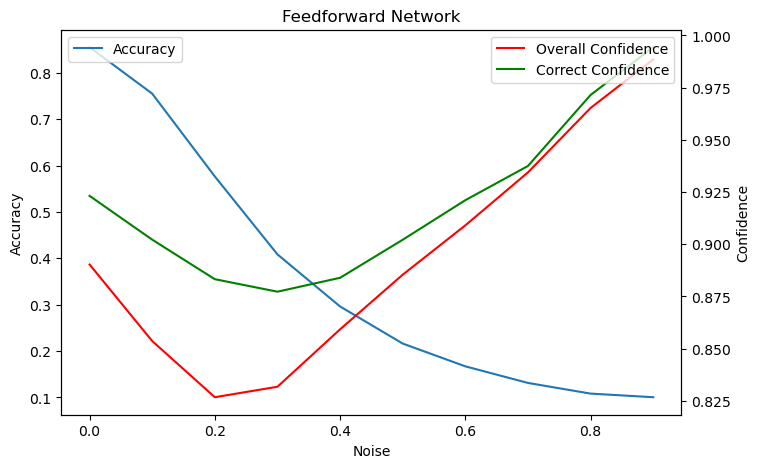

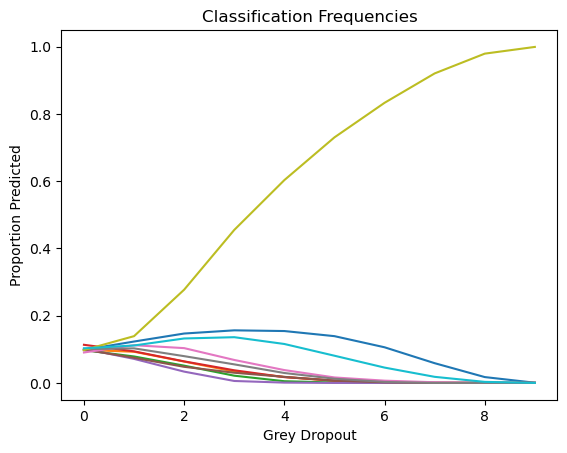

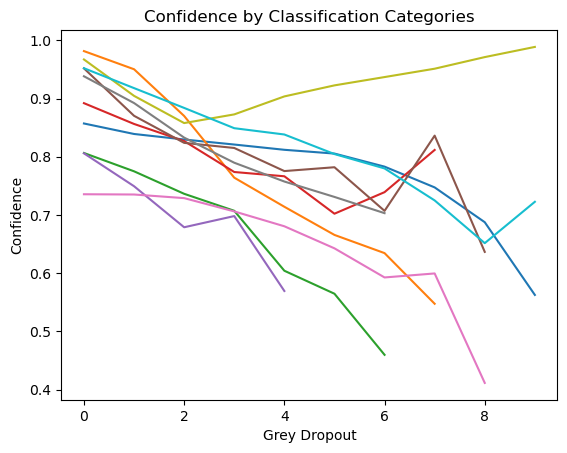

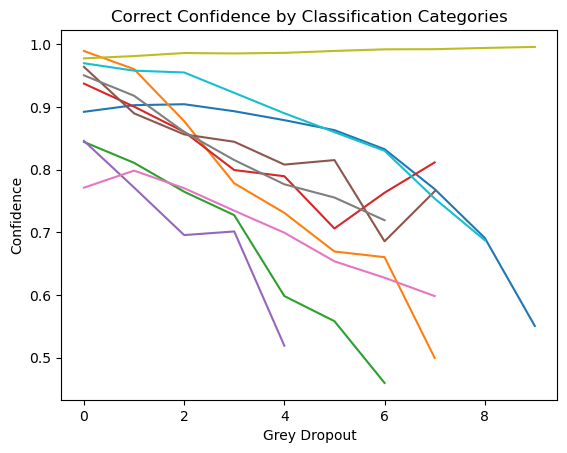

<Figure size 640x480 with 0 Axes>

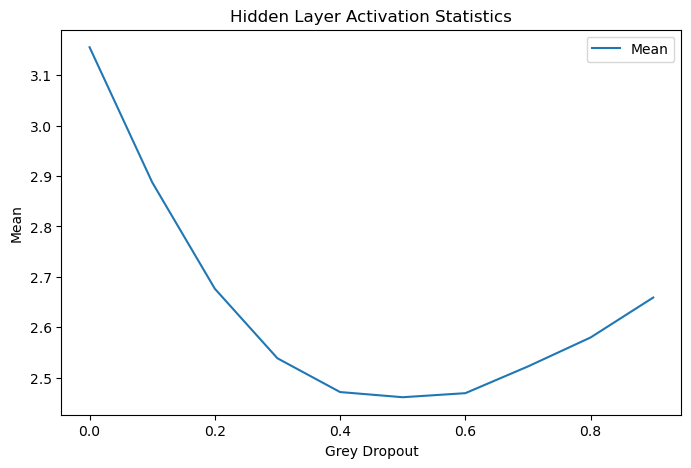

In [11]:
# Vary grey dropout


sd_test = np.arange(0,1,.1)

all_conf_array = []
correct_conf_array = []
acc_array = []

conf_cat_all_array = np.empty((10,0))
conf_cat_correct_array = np.empty((10,0))
freq_all = np.empty((10,0))

activation_mean = []

for i in range(len(sd_test)):
    images_testing_noise = generate_pixel_dropout(images_testing,sd_test[i],0.5)
    images_testing_noise_flat = images_testing_noise.reshape(np.shape(images_testing_noise)[0],784)
    labels_testing_predicted = model_feedforward.predict(images_testing_noise_flat)
    
    all_conf,correct_conf = compute_confidence(labels_testing,labels_testing_predicted)
    acc = compute_accuracy(labels_testing,labels_testing_predicted)
    
    all_conf_array.append(all_conf)
    correct_conf_array.append(correct_conf)   
    acc_array.append(acc)
    
    freq = compute_frequencies(labels_testing_predicted)
    
    freq_all = np.hstack((freq_all,freq))
    
    conf_cat_all, conf_cat_correct = compute_confidence_by_category(labels_testing,labels_testing_predicted)
    

    
    conf_cat_all_array = np.hstack((conf_cat_all_array,conf_cat_all))
    conf_cat_correct_array = np.hstack((conf_cat_correct_array,conf_cat_correct))
    
    
    hidden_activation = model_feedforward_intermed.predict(images_testing_noise_flat)
    
    activation_mean.append(np.mean(hidden_activation))

plt.figure(1)
fig, acc_ax = plt.subplots(figsize=(8,5))
conf_ax = acc_ax.twinx()
acc_ax.set_xlabel("Noise")
acc_ax.set_ylabel("Accuracy")
conf_ax.set_ylabel("Confidence")
acc_ax.plot(sd_test,acc_array, label = "Accuracy")
conf_ax.plot(sd_test,all_conf_array, label = "Overall Confidence",color='r')
conf_ax.plot(sd_test,correct_conf_array, label = "Correct Confidence",color='g')
plt.title("Feedforward Network")
conf_ax.legend(loc= "upper right")
acc_ax.legend(loc= "upper left")
plt.show()

plt.figure(2)
for i in range(10):
    plt.plot(freq_all[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Proportion Predicted")
plt.title("Classification Frequencies")
plt.show()

plt.figure(3)
for i in range(10):
    plt.plot(conf_cat_all_array[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Confidence")
plt.title("Confidence by Classification Categories")
plt.show()

plt.figure(4)
for i in range(10):
    plt.plot(conf_cat_correct_array[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Confidence")
plt.title("Correct Confidence by Classification Categories")
plt.show()


plt.figure(5)
fig, mean_ax = plt.subplots(figsize=(8,5))
#var_ax = mean_ax.twinx()
mean_ax.set_xlabel("Grey Dropout")
mean_ax.set_ylabel("Mean")
#var_ax.set_ylabel("Variance")
mean_ax.plot(sd_test,activation_mean, label = "Mean")
#var_ax.plot(sd_test,activation_var, label = "Var",color='r')
plt.title("Hidden Layer Activation Statistics")
mean_ax.legend(loc= "upper right")
#var_ax.legend(loc= "upper left")
plt.show()

In [ ]:
# Vary black dropout


sd_test = np.arange(0,1,.1)

all_conf_array = []
correct_conf_array = []
acc_array = []

conf_cat_all_array = np.empty((10,0))
conf_cat_correct_array = np.empty((10,0))
freq_all = np.empty((10,0))

activation_mean = []

for i in range(len(sd_test)):
    images_testing_noise = generate_pixel_dropout(images_testing,sd_test[i],0)
    images_testing_noise_flat = images_testing_noise.reshape(np.shape(images_testing_noise)[0],784)
    labels_testing_predicted = model_feedforward.predict(images_testing_noise_flat)
    
    all_conf,correct_conf = compute_confidence(labels_testing,labels_testing_predicted)
    acc = compute_accuracy(labels_testing,labels_testing_predicted)
    
    all_conf_array.append(all_conf)
    correct_conf_array.append(correct_conf)   
    acc_array.append(acc)
    
    freq = compute_frequencies(labels_testing_predicted)
    
    freq_all = np.hstack((freq_all,freq))
    
    conf_cat_all, conf_cat_correct = compute_confidence_by_category(labels_testing,labels_testing_predicted)
    

    
    conf_cat_all_array = np.hstack((conf_cat_all_array,conf_cat_all))
    conf_cat_correct_array = np.hstack((conf_cat_correct_array,conf_cat_correct))
    
    
    hidden_activation = model_feedforward_intermed.predict(images_testing_noise_flat)
    
    activation_mean.append(np.mean(hidden_activation))

plt.figure(1)
fig, acc_ax = plt.subplots(figsize=(8,5))
conf_ax = acc_ax.twinx()
acc_ax.set_xlabel("Noise")
acc_ax.set_ylabel("Accuracy")
conf_ax.set_ylabel("Confidence")
acc_ax.plot(sd_test,acc_array, label = "Accuracy")
conf_ax.plot(sd_test,all_conf_array, label = "Overall Confidence",color='r')
conf_ax.plot(sd_test,correct_conf_array, label = "Correct Confidence",color='g')
plt.title("Feedforward Network")
conf_ax.legend(loc= "upper right")
acc_ax.legend(loc= "upper left")
plt.show()

plt.figure(2)
for i in range(10):
    plt.plot(freq_all[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Proportion Predicted")
plt.title("Classification Frequencies")
plt.show()

plt.figure(3)
for i in range(10):
    plt.plot(conf_cat_all_array[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Confidence")
plt.title("Confidence by Classification Categories")
plt.show()

plt.figure(4)
for i in range(10):
    plt.plot(conf_cat_correct_array[i,:])

plt.xlabel("Grey Dropout")
plt.ylabel("Confidence")
plt.title("Correct Confidence by Classification Categories")
plt.show()


plt.figure(5)
fig, mean_ax = plt.subplots(figsize=(8,5))
#var_ax = mean_ax.twinx()
mean_ax.set_xlabel("Black Dropout")
mean_ax.set_ylabel("Mean")
#var_ax.set_ylabel("Variance")
mean_ax.plot(sd_test,activation_mean, label = "Mean")
#var_ax.plot(sd_test,activation_var, label = "Var",color='r')
plt.title("Hidden Layer Activation Statistics")
mean_ax.legend(loc= "upper right")
#var_ax.legend(loc= "upper left")
plt.show()

<Figure size 640x480 with 0 Axes>

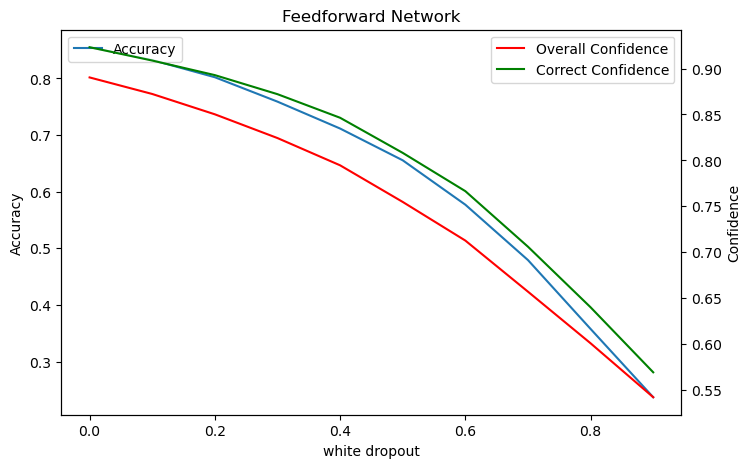

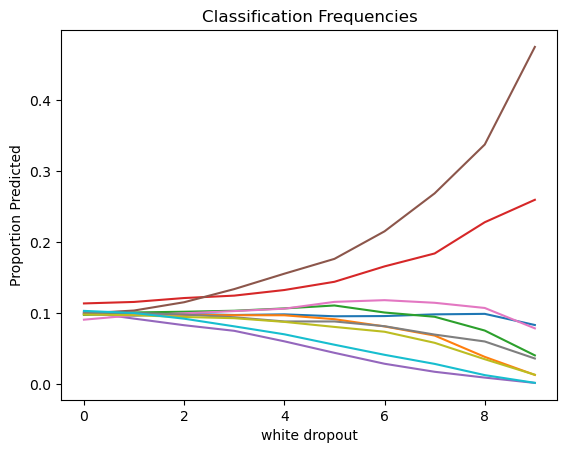

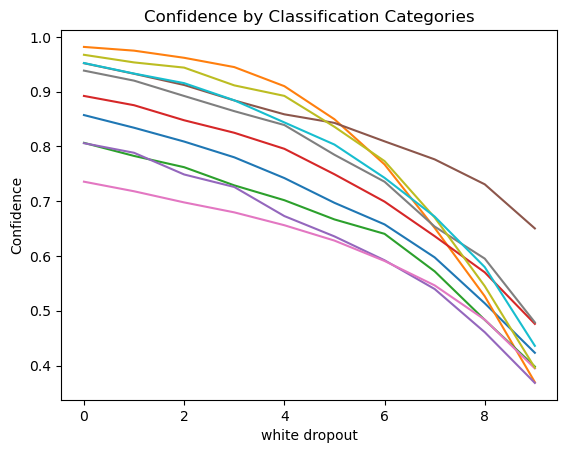

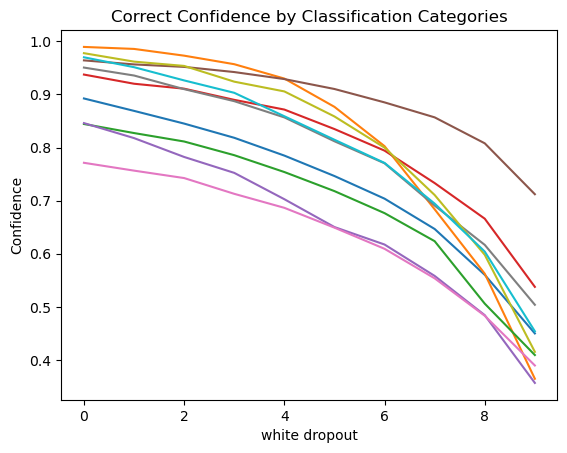

<Figure size 640x480 with 0 Axes>

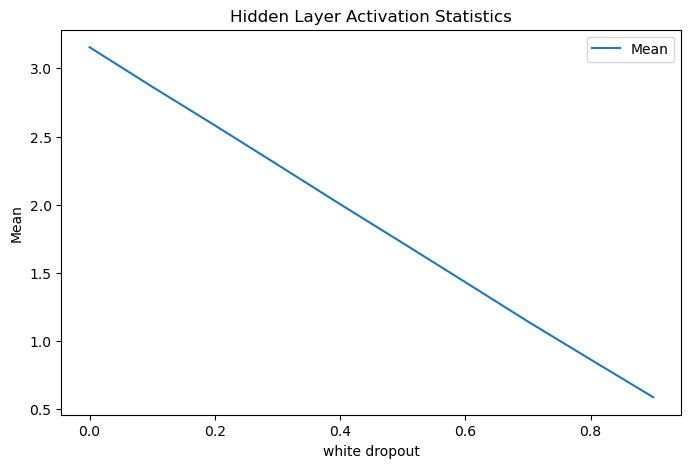

In [12]:
# Vary white dropout


sd_test = np.arange(0,1,.1)

all_conf_array = []
correct_conf_array = []
acc_array = []

conf_cat_all_array = np.empty((10,0))
conf_cat_correct_array = np.empty((10,0))
freq_all = np.empty((10,0))

activation_mean = []

for i in range(len(sd_test)):
    images_testing_noise = generate_pixel_dropout(images_testing,sd_test[i],0)
    images_testing_noise_flat = images_testing_noise.reshape(np.shape(images_testing_noise)[0],784)
    labels_testing_predicted = model_feedforward.predict(images_testing_noise_flat)
    
    all_conf,correct_conf = compute_confidence(labels_testing,labels_testing_predicted)
    acc = compute_accuracy(labels_testing,labels_testing_predicted)
    
    all_conf_array.append(all_conf)
    correct_conf_array.append(correct_conf)   
    acc_array.append(acc)
    
    freq = compute_frequencies(labels_testing_predicted)
    
    freq_all = np.hstack((freq_all,freq))
    
    conf_cat_all, conf_cat_correct = compute_confidence_by_category(labels_testing,labels_testing_predicted)
    

    
    conf_cat_all_array = np.hstack((conf_cat_all_array,conf_cat_all))
    conf_cat_correct_array = np.hstack((conf_cat_correct_array,conf_cat_correct))
    
    
    hidden_activation = model_feedforward_intermed.predict(images_testing_noise_flat)
    
    activation_mean.append(np.mean(hidden_activation))

plt.figure(1)
fig, acc_ax = plt.subplots(figsize=(8,5))
conf_ax = acc_ax.twinx()
acc_ax.set_xlabel("white dropout")
acc_ax.set_ylabel("Accuracy")
conf_ax.set_ylabel("Confidence")
acc_ax.plot(sd_test,acc_array, label = "Accuracy")
conf_ax.plot(sd_test,all_conf_array, label = "Overall Confidence",color='r')
conf_ax.plot(sd_test,correct_conf_array, label = "Correct Confidence",color='g')
plt.title("Feedforward Network")
conf_ax.legend(loc= "upper right")
acc_ax.legend(loc= "upper left")
plt.show()

plt.figure(2)
for i in range(10):
    plt.plot(freq_all[i,:])

plt.xlabel("white dropout")
plt.ylabel("Proportion Predicted")
plt.title("Classification Frequencies")
plt.show()

plt.figure(3)
for i in range(10):
    plt.plot(conf_cat_all_array[i,:])

plt.xlabel("white dropout")
plt.ylabel("Confidence")
plt.title("Confidence by Classification Categories")
plt.show()

plt.figure(4)
for i in range(10):
    plt.plot(conf_cat_correct_array[i,:])

plt.xlabel("white dropout")
plt.ylabel("Confidence")
plt.title("Correct Confidence by Classification Categories")
plt.show()


plt.figure(5)
fig, mean_ax = plt.subplots(figsize=(8,5))
#var_ax = mean_ax.twinx()
mean_ax.set_xlabel("white dropout")
mean_ax.set_ylabel("Mean")
#var_ax.set_ylabel("Variance")
mean_ax.plot(sd_test,activation_mean, label = "Mean")
#var_ax.plot(sd_test,activation_var, label = "Var",color='r')
plt.title("Hidden Layer Activation Statistics")
mean_ax.legend(loc= "upper right")
#var_ax.legend(loc= "upper left")
plt.show()

<ipython-input-4-2497c16af76f>:94: RuntimeWarning: invalid value encountered in true_divide
  all_conf[j] = all_conf[j]/cc[j]
<ipython-input-4-2497c16af76f>:95: RuntimeWarning: invalid value encountered in true_divide
  correct_conf[j] = correct_conf[j]/c[j]


<Figure size 640x480 with 0 Axes>

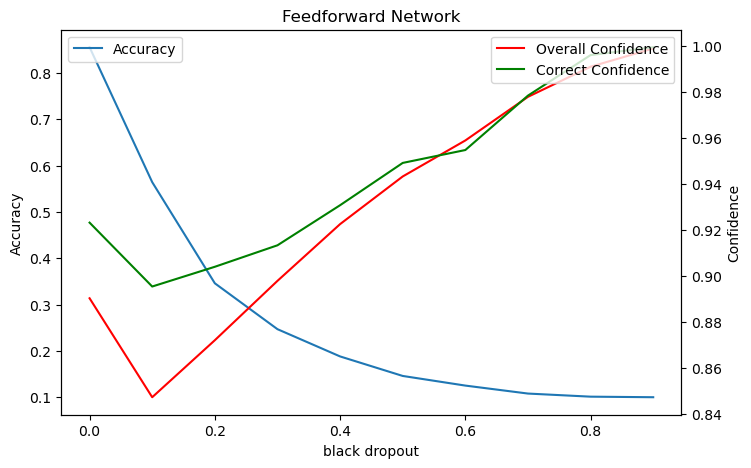

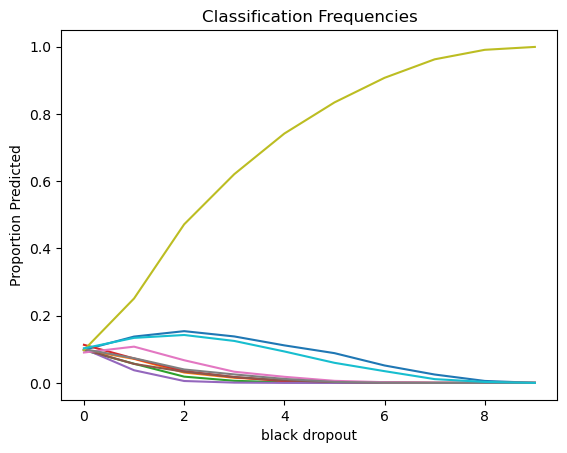

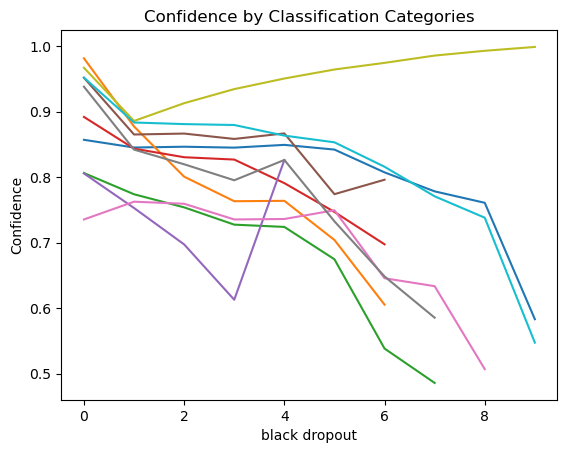

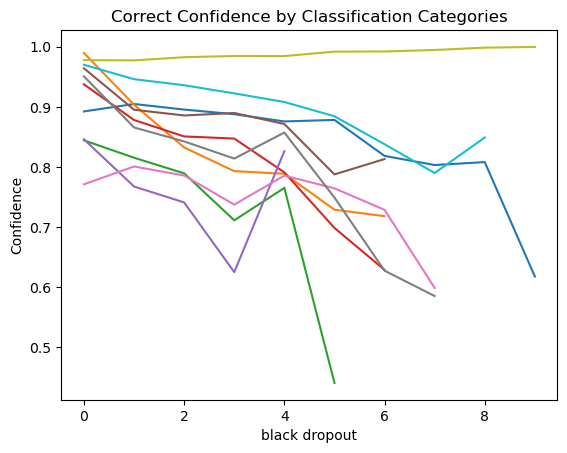

<Figure size 640x480 with 0 Axes>

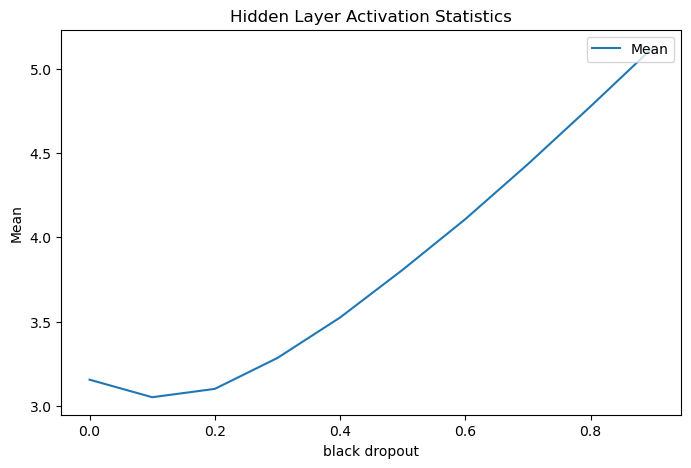

In [13]:
# Vary black dropout


sd_test = np.arange(0,1,.1)

all_conf_array = []
correct_conf_array = []
acc_array = []

conf_cat_all_array = np.empty((10,0))
conf_cat_correct_array = np.empty((10,0))
freq_all = np.empty((10,0))

activation_mean = []

for i in range(len(sd_test)):
    images_testing_noise = generate_pixel_dropout(images_testing,sd_test[i],1)
    images_testing_noise_flat = images_testing_noise.reshape(np.shape(images_testing_noise)[0],784)
    labels_testing_predicted = model_feedforward.predict(images_testing_noise_flat)
    
    all_conf,correct_conf = compute_confidence(labels_testing,labels_testing_predicted)
    acc = compute_accuracy(labels_testing,labels_testing_predicted)
    
    all_conf_array.append(all_conf)
    correct_conf_array.append(correct_conf)   
    acc_array.append(acc)
    
    freq = compute_frequencies(labels_testing_predicted)
    
    freq_all = np.hstack((freq_all,freq))
    
    conf_cat_all, conf_cat_correct = compute_confidence_by_category(labels_testing,labels_testing_predicted)
    

    
    conf_cat_all_array = np.hstack((conf_cat_all_array,conf_cat_all))
    conf_cat_correct_array = np.hstack((conf_cat_correct_array,conf_cat_correct))
    
    
    hidden_activation = model_feedforward_intermed.predict(images_testing_noise_flat)
    
    activation_mean.append(np.mean(hidden_activation))

plt.figure(1)
fig, acc_ax = plt.subplots(figsize=(8,5))
conf_ax = acc_ax.twinx()
acc_ax.set_xlabel("black dropout")
acc_ax.set_ylabel("Accuracy")
conf_ax.set_ylabel("Confidence")
acc_ax.plot(sd_test,acc_array, label = "Accuracy")
conf_ax.plot(sd_test,all_conf_array, label = "Overall Confidence",color='r')
conf_ax.plot(sd_test,correct_conf_array, label = "Correct Confidence",color='g')
plt.title("Feedforward Network")
conf_ax.legend(loc= "upper right")
acc_ax.legend(loc= "upper left")
plt.show()

plt.figure(2)
for i in range(10):
    plt.plot(freq_all[i,:])

plt.xlabel("black dropout")
plt.ylabel("Proportion Predicted")
plt.title("Classification Frequencies")
plt.show()

plt.figure(3)
for i in range(10):
    plt.plot(conf_cat_all_array[i,:])

plt.xlabel("black dropout")
plt.ylabel("Confidence")
plt.title("Confidence by Classification Categories")
plt.show()

plt.figure(4)
for i in range(10):
    plt.plot(conf_cat_correct_array[i,:])

plt.xlabel("black dropout")
plt.ylabel("Confidence")
plt.title("Correct Confidence by Classification Categories")
plt.show()


plt.figure(5)
fig, mean_ax = plt.subplots(figsize=(8,5))
#var_ax = mean_ax.twinx()
mean_ax.set_xlabel("black dropout")
mean_ax.set_ylabel("Mean")
#var_ax.set_ylabel("Variance")
mean_ax.plot(sd_test,activation_mean, label = "Mean")
#var_ax.plot(sd_test,activation_var, label = "Var",color='r')
plt.title("Hidden Layer Activation Statistics")
mean_ax.legend(loc= "upper right")
#var_ax.legend(loc= "upper left")
plt.show()